Loaded WRF_interp_T_2000-03.nc with Dask chunks
Loaded WRF_interp_QRAIN_2000-03.nc with Dask chunks
Loaded WRF_interp_QSNOW_2000-03.nc with Dask chunks
Loaded WRF_interp_QICE_2000-03.nc with Dask chunks
Loaded WRF_interp_QGRAUP_2000-03.nc with Dask chunks


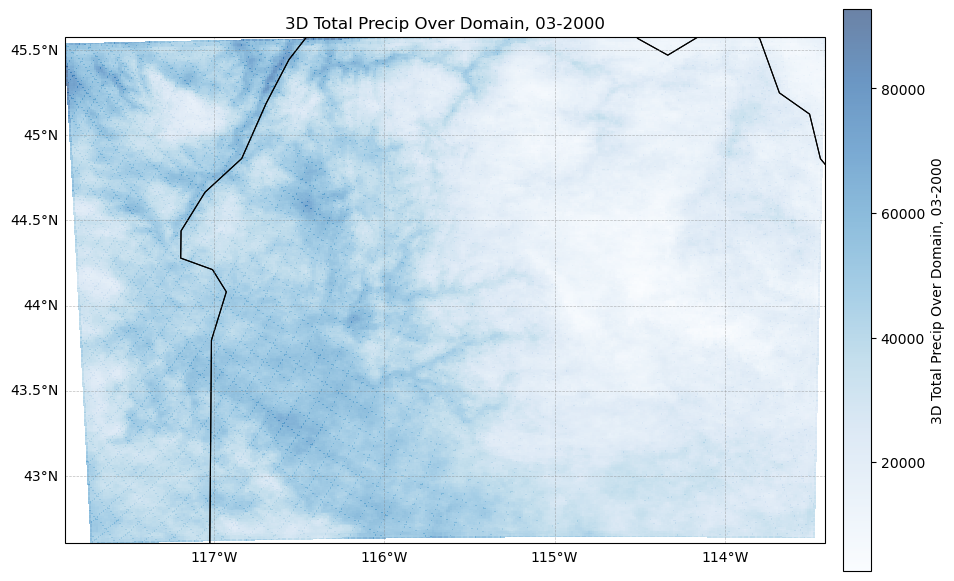

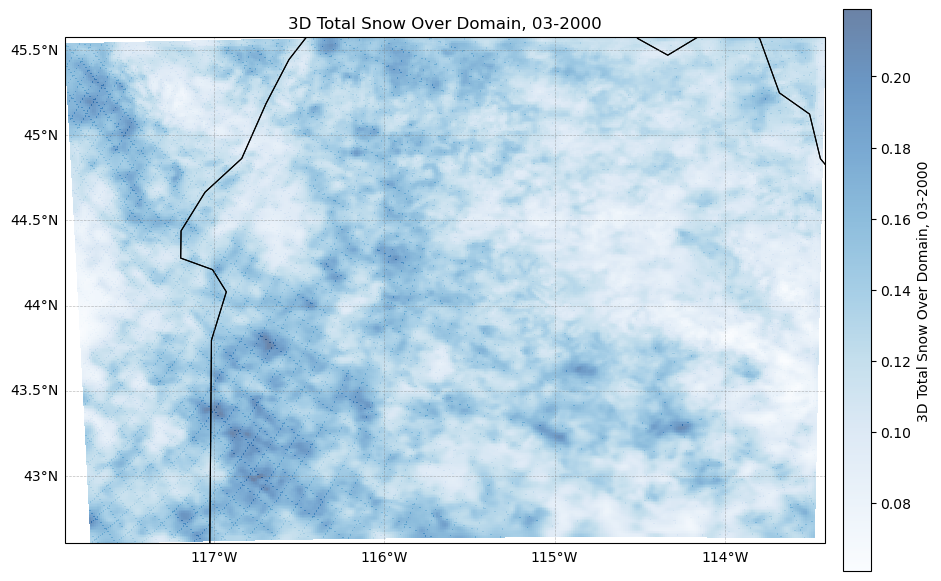

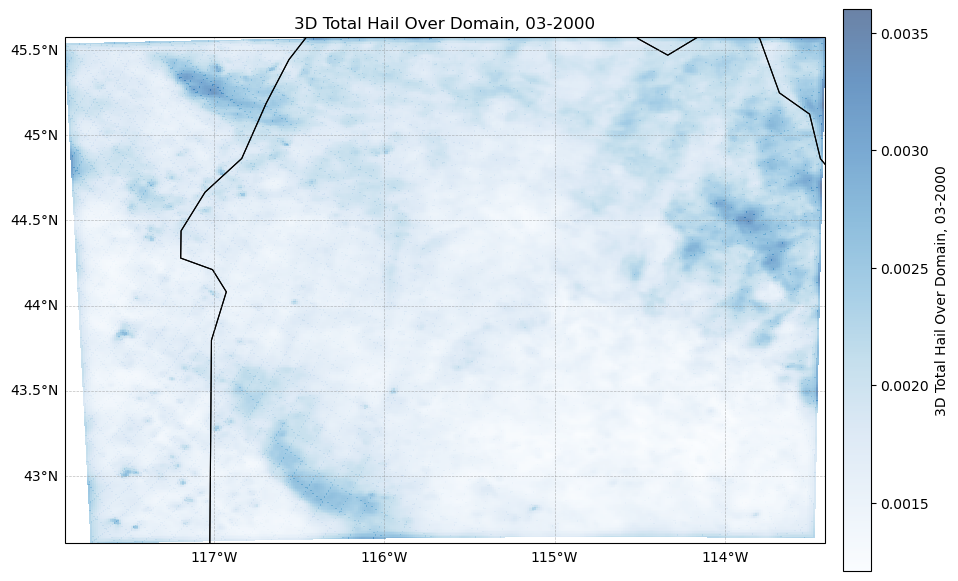

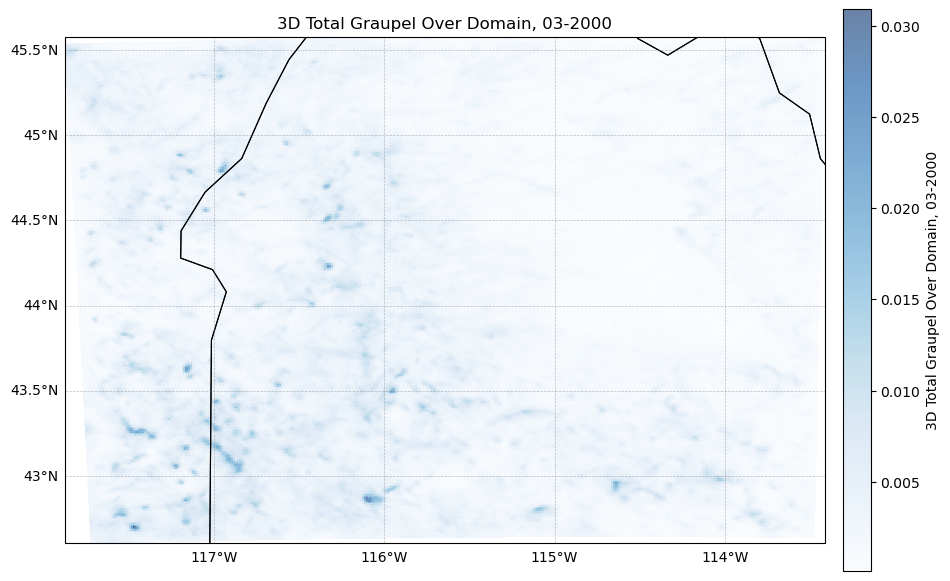

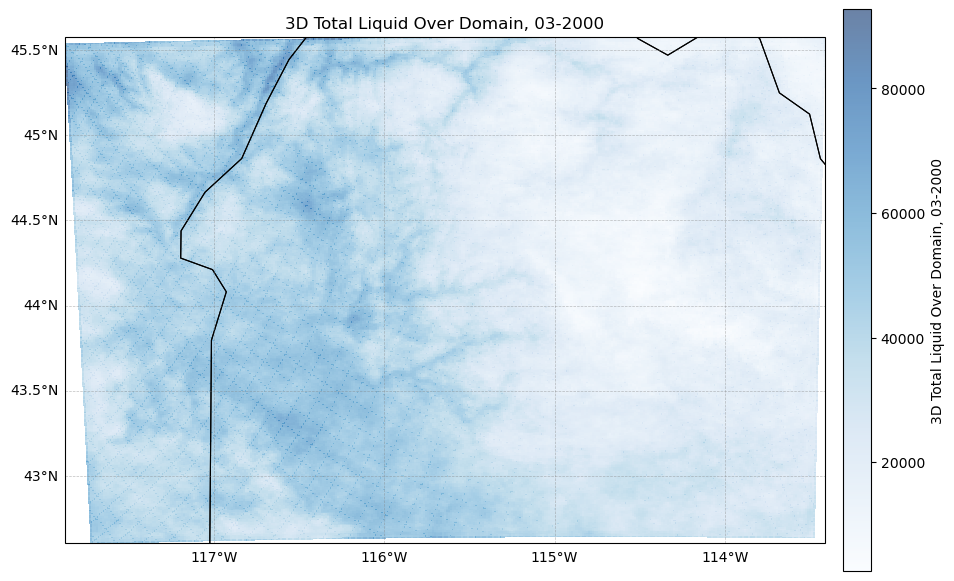

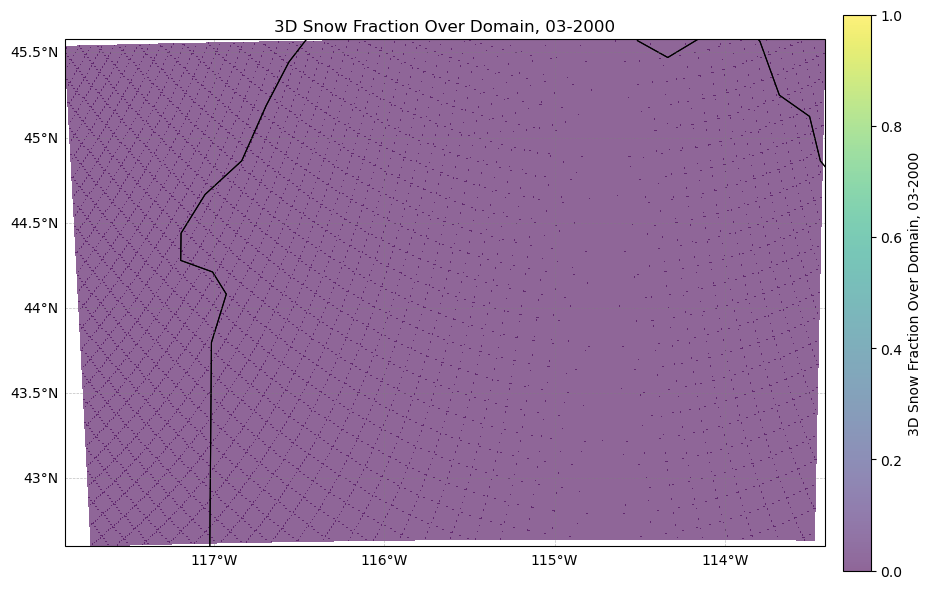

In [3]:
import os
import numpy as np
import dask
import matplotlib.pyplot as plt
from importlib import reload
import plot_utils
reload(plot_utils)
from plot_utils import plot_cartopy, load_wrf_var, fix_accum_reset

# === DATA DIRECTORY (3-D, interpolated) ===
interp3d_dir = "/bsushare/leaf-shared/subset-output-wrf/lev_interpolated/vol04/wrf_out/wy_2000/d02/"

# === CONFIG ===
month           = "03"
year            = "2000"
target_location = "Domain"
epsilon         = 1e-6   # to avoid division by zero
min_precip      = 1.0    # mm, mask threshold

# === LOAD COORDINATES FROM 3-D T file ===
t3d = load_wrf_var("WRF_interp_T", interp3d_dir, year, month)
lats = t3d["XLAT"][0].values
lons = t3d["XLONG"][0].values

# === LOAD 3-D MIXING RATIOS ===
rain3d  = load_wrf_var("WRF_interp_QRAIN", interp3d_dir, year, month)["QRAIN"]
snow3d  = load_wrf_var("WRF_interp_QSNOW", interp3d_dir, year, month)["QSNOW"]
hail3d  = load_wrf_var("WRF_interp_QICE",  interp3d_dir, year, month)["QICE"]
graup3d = load_wrf_var("WRF_interp_QGRAUP",interp3d_dir, year, month)["QGRAUP"]

# === INTEGRATE IN TIME ===
# rain3d: use fix_accum_reset → (level, y, x)
rain_vert = fix_accum_reset(rain3d)
# for others: diff→clip→sum over Time
snow_vert  = snow3d.diff("Time").clip(min=0).sum("Time")
hail_vert  = hail3d.diff("Time").clip(min=0).sum("Time")
graup_vert = graup3d.diff("Time").clip(min=0).sum("Time")

# === VERTICAL INTEGRATION ===
rain2d_da  = rain_vert.sum(dim="level")
snow2d_da  = snow_vert.sum(dim="level")
hail2d_da  = hail_vert.sum(dim="level")
graup2d_da = graup_vert.sum(dim="level")

# === LAZY COMPUTE ALL 4 AT ONCE ===
rain2d, snow2d, hail2d, graup2d = dask.compute(
    rain2d_da, snow2d_da, hail2d_da, graup2d_da
)

# bring into NumPy
rain2d  = rain2d.values
snow2d  = snow2d.values
hail2d  = hail2d.values
graup2d = graup2d.values

# derive liquid & fraction
liquid2d = rain2d - (snow2d + hail2d + graup2d)
frac2d   = snow2d / (rain2d + epsilon)

# === MASK LOW VALUES ===
mask      = rain2d < min_precip
rain_ma   = np.ma.masked_array(rain2d,  mask=mask)
snow_ma   = np.ma.masked_array(snow2d,  mask=mask)
hail_ma   = np.ma.masked_array(hail2d,  mask=mask)
graup_ma  = np.ma.masked_array(graup2d, mask=mask)
liquid_ma = np.ma.masked_array(liquid2d,mask=mask)
frac_ma   = np.ma.masked_invalid(frac2d)

# === PLOT ===
plot_cartopy(lons, lats, rain_ma,
    f"3D Total Precip Over {target_location}, {month}-{year}", cmap="Blues")

plot_cartopy(lons, lats, snow_ma,
    f"3D Total Snow Over {target_location}, {month}-{year}", cmap="Blues")

plot_cartopy(lons, lats, hail_ma,
    f"3D Total Hail Over {target_location}, {month}-{year}", cmap="Blues")

plot_cartopy(lons, lats, graup_ma,
    f"3D Total Graupel Over {target_location}, {month}-{year}", cmap="Blues")

plot_cartopy(lons, lats, liquid_ma,
    f"3D Total Liquid Over {target_location}, {month}-{year}", cmap="Blues")

plot_cartopy(lons, lats, frac_ma,
    f"3D Snow Fraction Over {target_location}, {month}-{year}",
    cmap="viridis", vmin=0, vmax=1)
